# Setup

In [1]:
# load libraries
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# control the figure size
plt.rcParams["figure.figsize"] = (20,3)

# Set random seed for reproducibility
np.random.seed(42)


In [2]:
# load demand data
demand_data = pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/demand.csv',
    dtype={"Month": str, "Date": int, "Demand": int})

# load intake price data
intake_price_data =  pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/intake_price.csv',
    dtype={"Intake": int, "Price": float})

In [3]:
# inspect demand data
demand_data.head()

,Month,Date,Demand
0,December,1,94
1,December,2,304
2,December,3,70
3,December,4,222
4,December,5,123


In [4]:
# inspect intake price data
intake_price_data.head()

,Intake,Price
0,20,1.0
1,24,1.0
2,31,1.0
3,34,1.0
4,37,1.0


# Decision Variables

In [5]:
# decision variables
calng_price = 7.50 # set by CaLNG

# Utility (Actual Usage)

In [6]:
def determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, total_lng_intake):
    '''
    this function determines the actual usage given CaLNG's price and peak intake from pipeline

    inputs:
    - calng_price: price set by CaLNG
    - peak_intake_from_pipeline: maximum intake from pipeline, after which consume LNG
    - demand_data: observed demand data (Month, Data, Demand in MMcF)
    - total_lng_intake: maximum amount ogf LNG to be used over the season

    outputs:
    - usage_data: usage data given observed demand, CaLNG price, and peak intake from pipeline
    '''
    usage_data = demand_data.copy()

    # set price index
    usage_data.reset_index(inplace=True, drop=False)
    usage_data = usage_data.rename(columns={'index': 'price_index'})

    usage_data['pipeline_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['Demand'] - 144)/60)), axis=1)
    usage_data['cost_from_pipeline_only'] = usage_data['Demand'] * usage_data['pipeline_price']
    usage_data['demand_for_lng'] = usage_data.apply(lambda row: max(row['Demand'] - peak_intake_from_pipeline, 0), axis=1)
    usage_data['purchase_from_calng'] = 0

    accumulated_lng_usage = 0

    for index, row in usage_data.iterrows():
        purchase =  min(row['demand_for_lng'], total_lng_intake - accumulated_lng_usage)
        usage_data.loc[index, 'purchase_from_calng'] = purchase
        accumulated_lng_usage = accumulated_lng_usage + purchase


    usage_data['pipeline_intake'] = usage_data['Demand']-usage_data['purchase_from_calng']
    usage_data['pipeline_intake_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['pipeline_intake'] - 144)/60)), axis=1)
    usage_data['cost_from_both'] = usage_data['pipeline_intake'] * usage_data['pipeline_intake_price'] + usage_data['purchase_from_calng'] * calng_price
    usage_data['savings'] = usage_data['cost_from_pipeline_only'] - usage_data['cost_from_both']

    return usage_data


In [7]:
def calculate_cost_statistics(usage_data, calng_price, peak_intake_from_pipeline, total_lng_purchase, return_data=False):
    cost_data = usage_data.copy()
    cost_data['pipeline_intake_cost'] = cost_data['pipeline_intake'] * cost_data['pipeline_intake_price']
    cost_data['calng_intake_cost'] = cost_data['purchase_from_calng'] * calng_price

    total_pipeline_intake = sum(cost_data['pipeline_intake'])
    total_calng_intake = sum(cost_data['purchase_from_calng'])

    total_pipeline_intake_cost = sum(cost_data['pipeline_intake_cost']) * 1000
    total_calng_intake_cost = total_lng_purchase*calng_price * 1000
    total_utility_cost = total_pipeline_intake_cost + total_calng_intake_cost
    total_savings = sum(cost_data['savings']) * 1000

    average_demand = np.mean(cost_data['Demand'])
    average_price = math.exp(max(0, (average_demand - 144)/60))

    total_average_draw_daily = sum(cost_data['Demand']) * average_price * 1000

    if not return_data:
        print(f"CaLNG price: ${calng_price:<04}")

        print("---")
        print(f"Peak intake from pipeline: {peak_intake_from_pipeline:,.0f} MMcf")
        print(f"Total peak months intake from pipeline: {total_pipeline_intake:,.0f} MMcf")
        print(f"Total intake from CaLNG: {total_calng_intake:,.0f} MMcf")

        print("---")
        print(f"Total amount paid to pipeline: ${total_pipeline_intake_cost:,.0f}")
        print(f"Total amount paid to CaLNG: ${total_calng_intake_cost:,.0f}")
        print(f"Total cost for utility: ${total_utility_cost:,.0f}")
        print(f"Savings from using CaLNG: ${total_savings:,.0f}")

        print("---")
        print(f"Total cost if average draw daily: ${total_average_draw_daily:,.0f}")

    else:
        cost_stat_dict = {
            "peak_intake_from_pipeline": peak_intake_from_pipeline,
            "total_lng_purchase": total_lng_purchase,
            "total_pipeline_intake": total_pipeline_intake,
            "total_calng_intake": total_calng_intake,
            "total_pipeline_intake_cost": total_pipeline_intake_cost,
            "total_calng_intake_cost": total_calng_intake_cost,
            "total_utility_cost": total_utility_cost,
            "total_savings": total_savings,
            "total_average_draw_daily": total_average_draw_daily
        }

        return cost_stat_dict

# Option

In [8]:
# demand randomization parameters
mean_daily_demand = 144
std_dev_daily_demand = 59


# Option Optimization
In progress

In [10]:
# number of simulation draws per scenario
num_draws = 5000

# decision variables
total_lng_range = range(700, 1300, 50)
peak_intake_from_pipeline_range= range(170,200,5)

cost_stat_list = []

for total in total_lng_range:
    for peak in peak_intake_from_pipeline_range:
        sims = []
        for n in range(num_draws):
            # simulate demand data
            sim_demand_data = demand_data.copy()

            # generate sample
            demand_sample = np.round(np.random.normal(mean_daily_demand, std_dev_daily_demand, len(sim_demand_data)))
            demand_sample = np.where(demand_sample < 0, 0, demand_sample)

            sim_demand_data['Demand'] = demand_sample

            # get simulated usage data
            sim_usage_data = determine_actual_usage(sim_demand_data, calng_price, peak, total)
            cost_stat_dict = calculate_cost_statistics(sim_usage_data, calng_price, peak, total, return_data=True)


            sims.append(cost_stat_dict)


        cost_stat_list.append(np.mean(pd.DataFrame(sims), axis=0))

df = pd.DataFrame(cost_stat_list)



In [15]:
df.head()

,peak_intake_from_pipeline,total_lng_purchase,total_pipeline_intake,total_calng_intake,total_pipeline_intake_cost,total_calng_intake_cost,total_utility_cost,total_savings,total_average_draw_daily
0,170.0,700.0,12412.6562,698.4690,2.168338e+07,5250000.0,2.693338e+07,4.576516e+06,1.372451e+07
1,175.0,700.0,12418.4178,694.2092,2.100806e+07,5250000.0,2.625806e+07,5.261291e+06,1.372557e+07
2,180.0,700.0,12430.3524,681.5070,2.041503e+07,5250000.0,2.566503e+07,5.846932e+06,1.372335e+07
3,185.0,700.0,12456.7668,654.0160,2.003466e+07,5250000.0,2.528466e+07,6.554595e+06,1.372837e+07
4,190.0,700.0,12505.4240,607.5512,1.996643e+07,5250000.0,2.521643e+07,6.897966e+06,1.374131e+07


In [20]:
# Find the index of the minimum total utility cost
min_cost_idx = df['total_utility_cost'].idxmin()

# Find optimal parameters using the correct indexing
optimal_total_lng = df.loc[min_cost_idx, 'total_lng_purchase']
optimal_peak_intake = df.loc[min_cost_idx, 'peak_intake_from_pipeline']

# Print optimal results
print(f"Optimal Parameters:")
print(f"Total LNG: {optimal_total_lng:.0f} MMcf")
print(f"Peak Intake from Pipeline: {optimal_peak_intake:.0f} MMcf")
print(f"Expected Cost: ${df.loc[min_cost_idx, 'total_utility_cost']:,.2f}")


Optimal Parameters:
Total LNG: 900 MMcf
Peak Intake from Pipeline: 180 MMcf
Expected Cost: $25,092,620.95


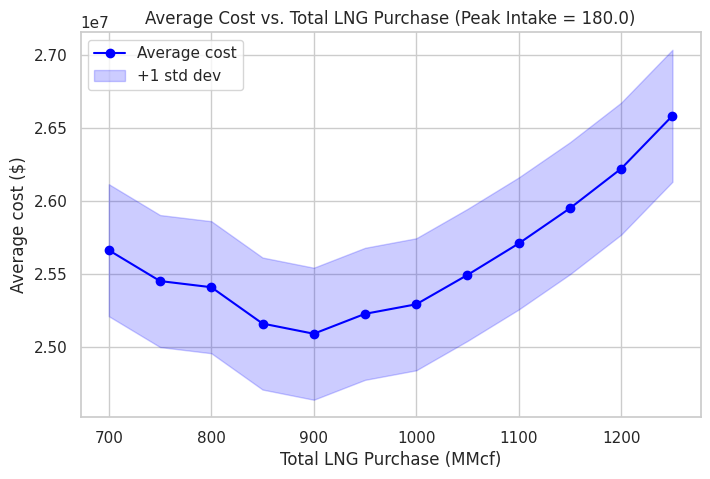

In [32]:
# Plot 1: Cost vs Total LNG at optimal peak intake
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))

# Find the index of the minimum total utility cost
min_cost_idx = df['total_utility_cost'].idxmin()

# Find optimal parameters using the correct indexing
optimal_total_lng = df.loc[min_cost_idx, 'total_lng_purchase']
optimal_peak_intake = df.loc[min_cost_idx, 'peak_intake_from_pipeline']

# Filter the dataframe for the given optimal peak intake from pipeline
df_opt_peak = df[df["peak_intake_from_pipeline"] == optimal_peak_intake]


# Plot Average cost vs. Total LNG purchase
plt.plot(df_opt_peak["total_lng_purchase"], df_opt_peak["total_utility_cost"],
         label="Average cost", marker='o', color="blue")

# Add a shaded area for ±1 standard deviation
plt.fill_between(df_opt_peak["total_lng_purchase"],
                 df_opt_peak["total_utility_cost"] - df_opt_peak["total_utility_cost"].std(),
                 df_opt_peak["total_utility_cost"] + df_opt_peak["total_utility_cost"].std(),
                 alpha=0.2, color="blue", label="+1 std dev")

# Add labels and title
plt.xlabel("Total LNG Purchase (MMcf)")
plt.ylabel("Average cost ($)")
plt.title(f"Average Cost vs. Total LNG Purchase (Peak Intake = {optimal_peak_intake})")

# Add legend
plt.legend()

# Show the plot
plt.show()

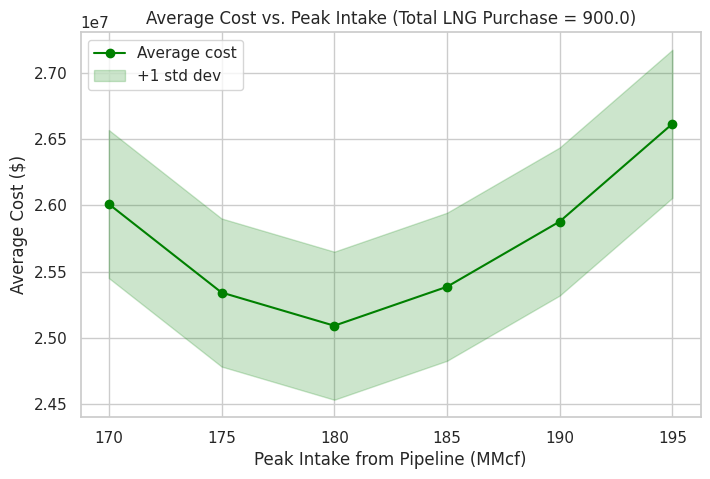

In [33]:
# Plot 2: Cost vs Peak Intake at optimal total LNG
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))

# Filter the dataframe for the given optimal total LNG purchase
df_opt_lng = df[df["total_lng_purchase"] == optimal_total_lng]

# Plot Average cost vs. Peak Intake from Pipeline
plt.plot(df_opt_lng["peak_intake_from_pipeline"], df_opt_lng["total_utility_cost"],
         label="Average cost", marker='o', color="green")

# Add a shaded area for ±1 standard deviation
plt.fill_between(df_opt_lng["peak_intake_from_pipeline"],
                 df_opt_lng["total_utility_cost"] - df_opt_lng["total_utility_cost"].std(),
                 df_opt_lng["total_utility_cost"] + df_opt_lng["total_utility_cost"].std(),
                 alpha=0.2, color="green", label="+1 std dev")

# Add labels and title
plt.xlabel("Peak Intake from Pipeline (MMcf)")
plt.ylabel("Average Cost ($)")
plt.title(f"Average Cost vs. Peak Intake (Total LNG Purchase = {optimal_total_lng})")

# Add legend
plt.legend()

# Show the plot
plt.show()
